### Imports

In [1]:
import os
import sys
# Set project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import pandas as pd

import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

#--- Get absolute path to the utils folder---
from pathlib import Path
utils_path = Path.cwd() / "utils"
sys.path.append(str(utils_path))

backtesting_path = Path.cwd() / "backtesting"
sys.path.append(str(backtesting_path))

from notebooks.utils.config_utils import load_config
from notebooks.utils.data_utils import load_dataset, preprocess_data
from notebooks.utils.model_utils import initialise_model, grid_search, get_feature_importance, optimise_threshold
from notebooks.utils.plotting_utils import plot_correlation, plot_scatter, plot_roc_and_prc, plot_classification_report, plot_point_biserial_correlation
from notebooks.utils.pdf_utils import create_markdown_report, update_markdown_with_model_details, convert_markdown_to_html, save_pdf_from_html

from notebooks.backtesting.backtester import Backtester

### Load config.yaml

In [2]:
# Test load
config = load_config('config_trailing.yaml')

Config loaded successfully!


### Load the dataset

In [3]:
df = load_dataset(config)
df_selected, selected_features, constructed_features, target_variable = preprocess_data(df, config)

df_selected

📁 Dataset Loaded: 3639 rows, 87 columns
✅ Dataset Preprocessed: 3637 rows, 25 columns


,id_odsp,date,season,league,country,home_team,away_team,score_pre_80,score_ft,leading_team_corners_70_75,...,leading_team_shots_75_80,trailing_team_shots_75_80,odds_ratio,shot_to_corner_ratio_pre_80,trailing_team_urgency_to_attack,trailing_team_momentum_to_attack,attack_intensity,defensive_pressure,trailing_team_probability,target
0,Aw5DflLH/,2011-08-06,2012,D1,germany,FC Augsburg,SC Freiburg,1-2,2-2,0,...,0,0,0.694,2.429,0.424,0.0,0,-4,42.373,1
1,CzPV312a/,2011-08-06,2012,F1,france,Paris Saint-Germain,Lorient,0-1,0-1,0,...,0,0,0.165,2.222,0.645,0.0,0,0,64.516,1
2,GUOdmtII/,2011-08-06,2012,F1,france,Caen,Valenciennes,1-0,1-0,0,...,0,0,0.725,1.900,0.000,0.0,0,-2,28.986,1
3,Wn69eU5B/,2011-08-06,2012,D1,germany,FC Cologne,VfL Wolfsburg,0-1,0-3,0,...,0,0,1.181,2.100,0.333,0.0,0,0,33.333,0
4,bkjpaC6n/,2011-08-06,2012,D1,germany,Werder Bremen,Kaiserslautern,1-0,2-0,1,...,2,0,0.381,2.300,0.000,0.0,4,0,20.833,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,r5V5rw33/,2017-01-22,2017,E0,england,Arsenal,Burnley,1-0,2-1,0,...,0,0,0.069,2.385,0.000,0.0,1,-1,5.634,0
3635,r5m8MY4G/,2017-01-22,2017,D1,germany,Bayer Leverkusen,Hertha Berlin,2-1,3-1,0,...,0,0,0.319,2.000,0.000,0.0,0,1,17.544,0
3636,trUaUcuk/,2017-01-22,2017,SP1,spain,Osasuna,Sevilla,2-3,3-4,0,...,0,0,4.304,2.556,0.147,0.0,1,0,14.706,0
3637,xSU9scI9/,2017-01-22,2017,E0,england,Chelsea,Hull,1-0,2-0,0,...,0,0,0.060,1.000,0.000,0.0,0,-2,5.000,0


### Plot correlation heatmap (for selected features)

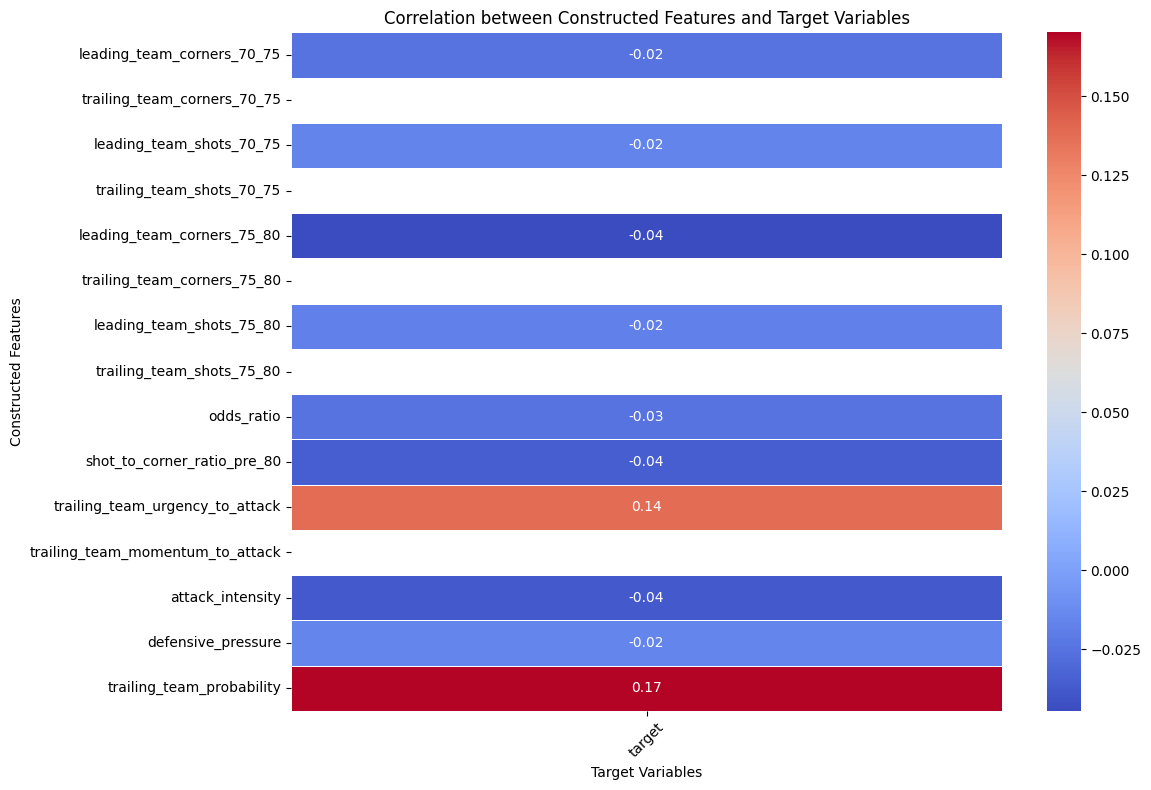

In [4]:
feature_correlation_image_path = plot_correlation(df_selected, selected_features, constructed_features, target_variable)

### Compute Point-Biserial Correlation and P-values

- **Point-biserial correlation**: Measures the strength and correlation between a binary variable (target) and continuous variables (each feature) (higher value better)
- **P-value**: Indicates if the correlation is statistically significant (lower value better)
- **Combined Score**: A reflective measure of both Point-biserial and P-val.

/Users/joshuagraham/Documents/LEEDS UNI/Year 4/COMP3931 - Individual Project/football-corner-prediction/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


--- TOP 10 FEATURES ---
Feature
trailing_team_probability          0.170204
trailing_team_urgency_to_attack    0.137776
leading_team_corners_75_80         0.044190
attack_intensity                   0.036662
shot_to_corner_ratio_pre_80        0.034716
odds_ratio                         0.021826
leading_team_corners_70_75         0.021064
leading_team_shots_75_80           0.013327
leading_team_shots_70_75           0.011574
defensive_pressure                 0.009701
Name: Combined Score, dtype: float64
-----------------------


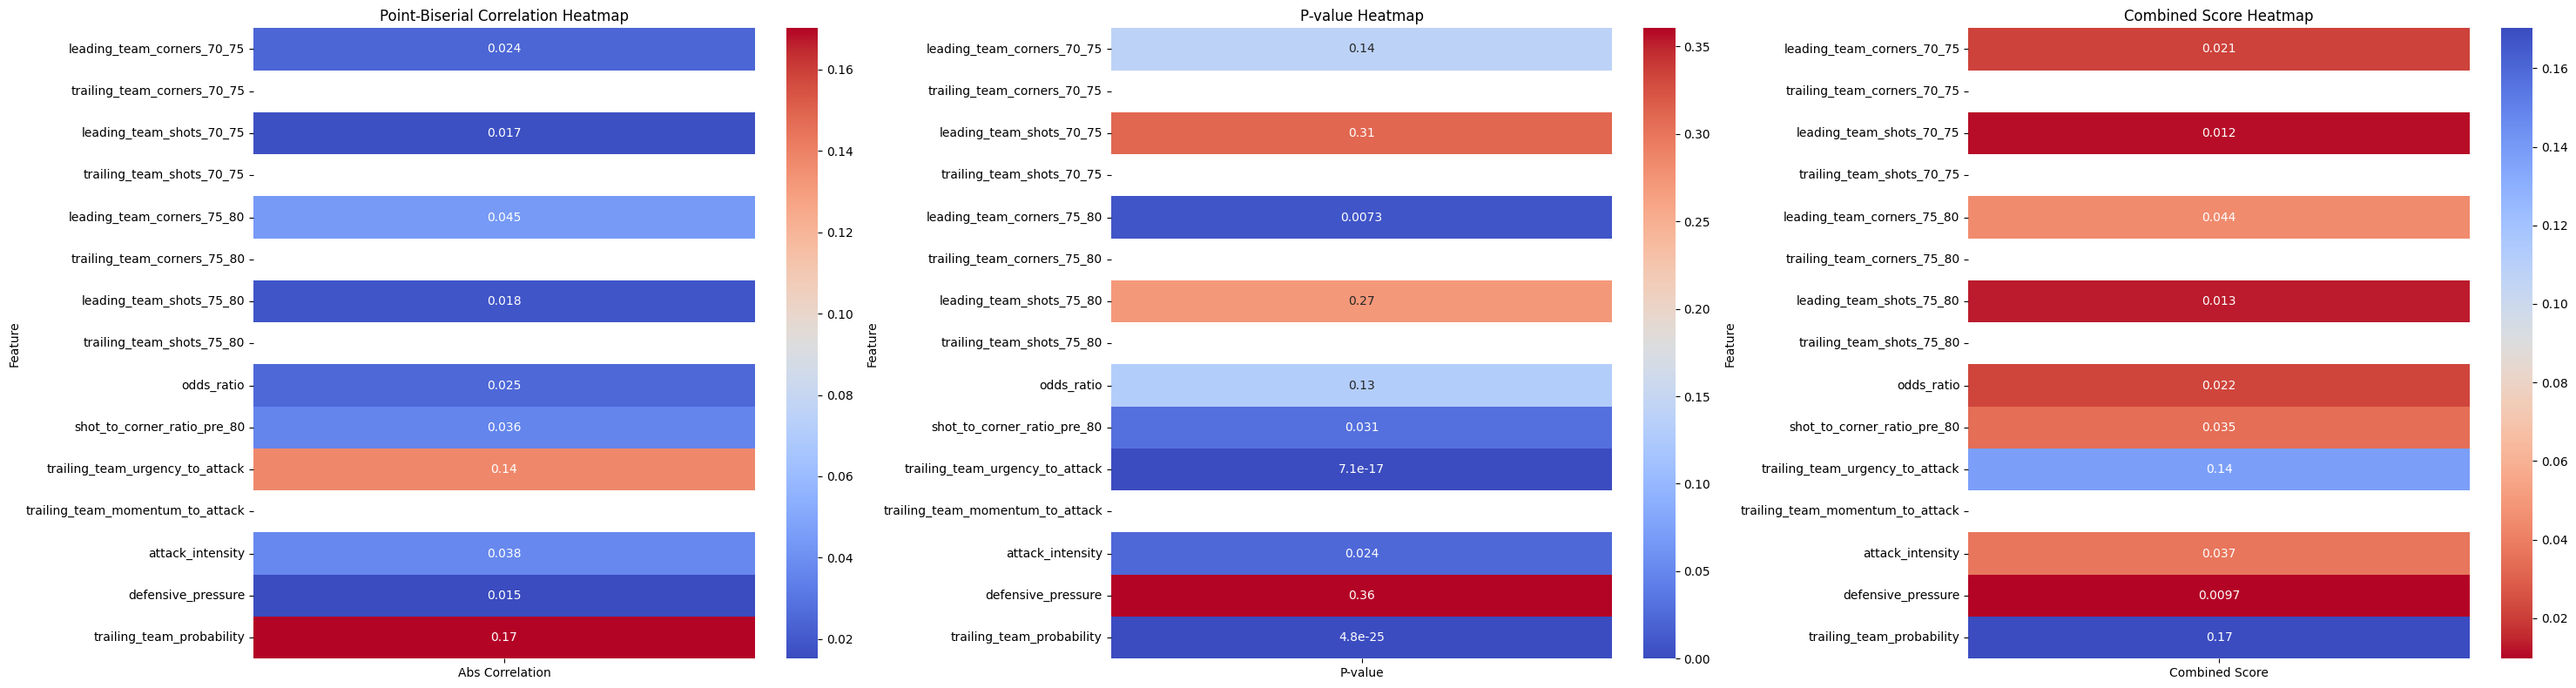

In [5]:
point_biserial_correlation_image_path = plot_point_biserial_correlation(df_selected, selected_features, constructed_features)

# Classification Pipeline

- **Feature Selection**: 
    - Trains only on selected and constructed features
- **Data Splitting**:
    - Exclude the last 500 rows for testing
    - Split remaining data into 80% train and 20% validation sets
- **Model Training Loop**:
    1) Initialise each model from config yaml
    2) Apply MinMax scaling... *only for models that require scaling*
    3) Perform grid search for hyperparameter tuning (if specified) and Train Model
    4) Predict on validation set and display feature importance
    5) Optimise precision-recall threshold
    6) Evaluate model on validation set using optimised threshold
    7) Plot ROC and Precision-Recall graphs
    8) Predict on the test set (last 500 rows) and evaluate
    9) Save the trained model
    10) Save predictions (for backtesting).
    11) Plot Scatter Graph.

In [ ]:
def run_classification_pipeline(config, df, selected_features, constructed_features, target_variable, show_output=False, generate_pdf=False): 
    models_to_train = config['model']['classification']['models']
    
    # Step 1: Create the Markdown for the report
    if generate_pdf:
        markdown_content = create_markdown_report(config, feature_correlation_image_path, point_biserial_correlation_image_path, target_variable, selected_features, constructed_features, models_to_train)   
    #Only train on selected and constructed features
    X = df[selected_features + constructed_features]
    y = df[target_variable]

    #Get num of 1s and 0s
    value_counts=y.value_counts()
    num_ones=value_counts.get(1, 0)
    num_zeros=value_counts.get(0, 0)
    total=value_counts.sum()
    implied_1_plus_betting_odds = round(1/(num_ones/total), 4)

    print("--- DATASET STATS ---")
    print(f"Number of 1's: {num_ones}")
    print(f"Number of 0's: {num_zeros}")
    print(f"Total: {total}")
    print(f"Implied 1+ betting odds = {implied_1_plus_betting_odds}")
    print("---------------------")

    #Split data to exclude the last 500 rows for testing
    train_data = df.iloc[:-500]
    test_data = df.iloc[-500:]

    # Split data -> train & validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_data[selected_features + constructed_features],
        train_data[target_variable],
        test_size=0.2,
        random_state=42,
        stratify=train_data[target_variable]
    )

    # Create X and y for testset
    X_test= test_data[selected_features+constructed_features]
    y_test =test_data[target_variable]

    # MinMax Scaling for models that require scaling...
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled =scaler.transform(X_val)
    X_test_scaled =scaler.transform(X_test)

    # --- MODEL TRAINING LOOP ---
    # Train and evaluate each model from the config
    models_to_train = config['model']['classification']['models']
    for model_name in models_to_train:
        print(f"\n-> Training {model_name}...")
    
        # Get the hyperparameters for the model
        hyperparameters = config["model"]["classification"]["hyperparameters"].get(model_name, {})
        do_grid_search=config["model"]["classification"].get("grid_search", False)

        # --- STEP 1: Initialise the model
        model = initialise_model(model_name, hyperparameters)

        # --- STEP 2: Select Scaled or Unscaled Data ---
        if model_name in ["logistic_regression", "svc", "xgboost"]:
            X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled
        
        # --- STEP 3: Grid Search (optional) ---
        if do_grid_search:
            optimal_model = grid_search(model_name, model, X_train, y_train, show_output)
        else:
            model.fit(X_train, y_train)
            optimal_model = model

        # --- STEP 4: Predict on the validation set ---
        y_pred_val = optimal_model.predict_proba(X_val)[:, 1]

        #Display Feature Importance
        feature_importances = get_feature_importance(optimal_model, model_name, selected_features, constructed_features)
        if show_output:
            print("\n### Top 8 and Bottom 5 Feature Importance ###")
            print(feature_importances)

        # --- STEP 5: Precision-Recall Threshold Optimisation ---
        best_threshold, optimal_threshold = optimise_threshold(y_pred_val, y_val, show_output)

        # optimal_threshold=0
        # --- STEP 6: Model Evaluation ---
        y_pred_threshold =(y_pred_val >= optimal_threshold).astype(int)
        if show_output:
            print(f"\n### Classification Report (threshold={optimal_threshold}):\n") 
            print(classification_report(y_val, y_pred_threshold))
        classification_report_str_1 = classification_report(y_val, y_pred_threshold, output_dict=False)

        # --- STEP 7: Plot ROC and Precision-Recall curves ---
        fpr,tpr,_ =roc_curve(y_val, y_pred_val)
        roc_auc =roc_auc_score(y_val, y_pred_val)
        precision,recall,_ =precision_recall_curve(y_val, y_pred_val)
        pr_auc=auc(recall, precision)

        # --- STEP 8: Test on test set (last 500 rows) ---
        # Predict on the final test data (last 500 rows)
        y_probs_final =optimal_model.predict_proba(X_test)[:, 1]
        y_pred_final=(y_probs_final >=optimal_threshold).astype(int)

        #Evaluate on the last 500 rows (final simulation)
        if show_output:
            print("\n### Prediction on last 500 rows: ###")
            print(classification_report(y_test, y_pred_final))
        classification_report_str_2 = classification_report(y_test, y_pred_final, output_dict=False)

        classification_report_image_path = plot_classification_report(optimal_model, X_val,y_val,X_test,y_test, model_name, show_output)
        roc_prc_image_path = plot_roc_and_prc(fpr, tpr, roc_auc,precision,recall, pr_auc,model_name,show_output)

        # --- STEP 9: Save Model ---
        model_dir = "../models" 
        if not os.path.exists(model_dir): # Ensure the directory exists
            os.makedirs(model_dir)
        # Save the model
        joblib.dump(optimal_model, os.path.join(model_dir, f"{model_name.replace(' ', '_').lower()}_model.pkl"))
        if show_output:
            print(f"{model_name} model saved.")

        prediction_file = f"../data/predictions/{model_name.replace(' ', '_').lower()}_predictions.csv"
        # --- STEP 10: Save Predictions ---
        results_df = pd.DataFrame({
            'kaggle_id': test_data['id_odsp'],
            'model_predicted_binary': y_pred_final,
            'actual_result': y_test
        })
        results_df.to_csv(prediction_file, index=False)
        if show_output:
            print(f"Predictions saved for {model_name}.")

        # --- STEP 11: Plot Scatter Graph ---
        scatter_image_path = plot_scatter(y_probs_final, y_test, model_name, show_output, optimal_threshold=optimal_threshold)

        if show_output:
            print(f"\n-> Running Backtest for {model_name}...")
        odds_file = config["paths"]["total_corner_odds"]  # Ensure this exists in config.yaml
        backtester = Backtester(config, odds_file=odds_file, model_file=prediction_file, model_type="classification", target_mean=implied_1_plus_betting_odds)
        backtesting_image_path, backtesting_results_list = backtester.run(show_output)

        if generate_pdf:
            #Finally, update markdown with generated outputs...
            markdown_content = update_markdown_with_model_details(
                markdown_content,
                model_name,
                feature_importances,
                best_threshold,
                classification_report_str_1,
                classification_report_str_2,
                classification_report_image_path,
                roc_prc_image_path,
                scatter_image_path,
                backtesting_results_list,
                backtesting_image_path
            )

    if generate_pdf:
        now = datetime.now()
        date_time_str = now.strftime("%Y-%m-%d, %H:%M")
        # Convert Markdown to html and save as pdf to reports/model_reports/
        html_content = convert_markdown_to_html(markdown_content)
        save_pdf_from_html(html_content, f'../reports/model_reports/{date_time_str}_model_report.pdf')
        print("📄 Saved PDF Report")
    
    print("✅ Finished Running Pipeline")

--- DATASET STATS ---
Number of 1's: 2066
Number of 0's: 1571
Total: 3637
Implied 1+ betting odds = 1.7604
---------------------

-> Training random_forest...

### Top 8 and Bottom 5 Feature Importance ###
                             Feature  Importance
8                         odds_ratio    0.244877
9        shot_to_corner_ratio_pre_80    0.233737
14         trailing_team_probability    0.226679
10   trailing_team_urgency_to_attack    0.097045
13                defensive_pressure    0.076796
2           leading_team_shots_70_75    0.035935
12                  attack_intensity    0.025129
0         leading_team_corners_70_75    0.024921
1        trailing_team_corners_70_75    0.000000
3          trailing_team_shots_70_75    0.000000
5        trailing_team_corners_75_80    0.000000
7          trailing_team_shots_75_80    0.000000
11  trailing_team_momentum_to_attack    0.000000

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
-----------

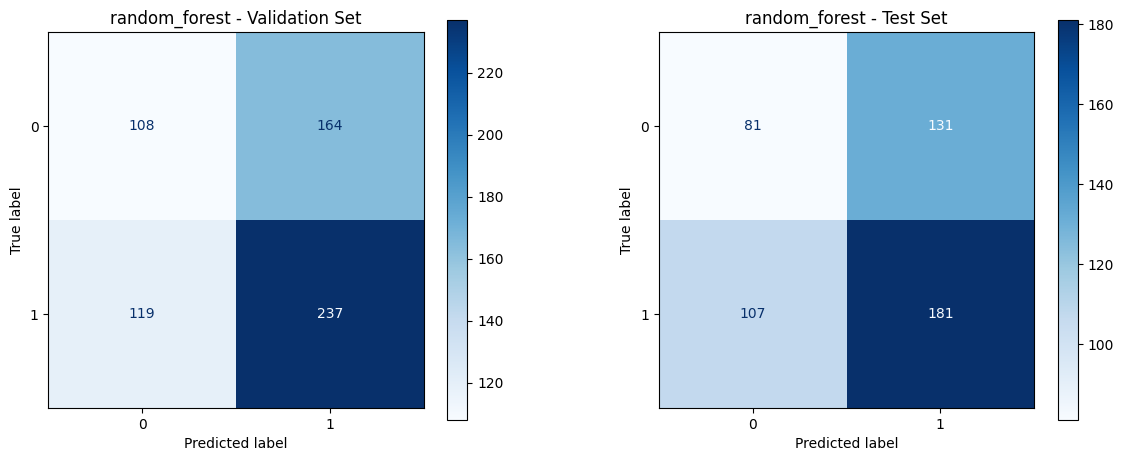

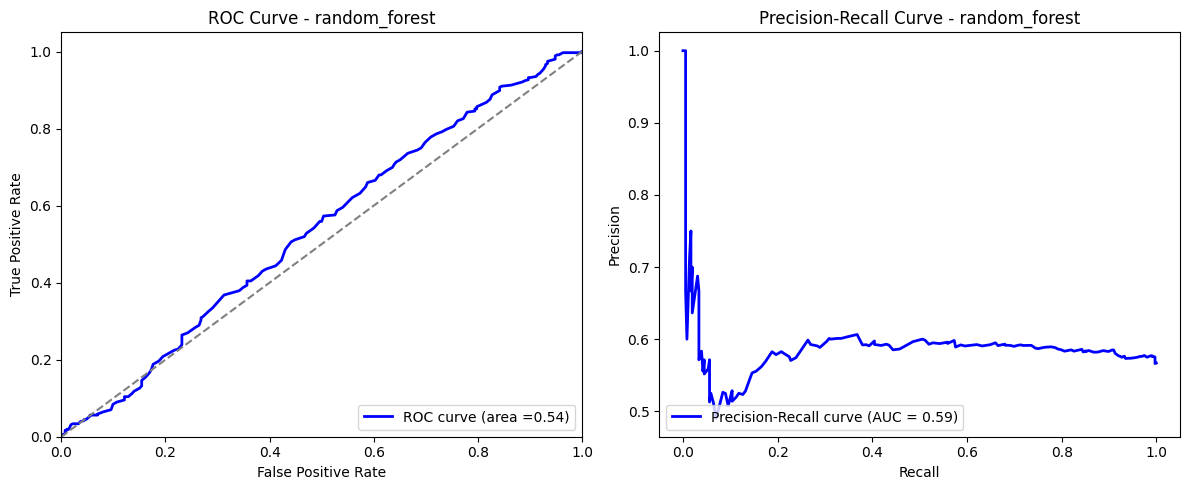

random_forest model saved.
Predictions saved for random_forest.


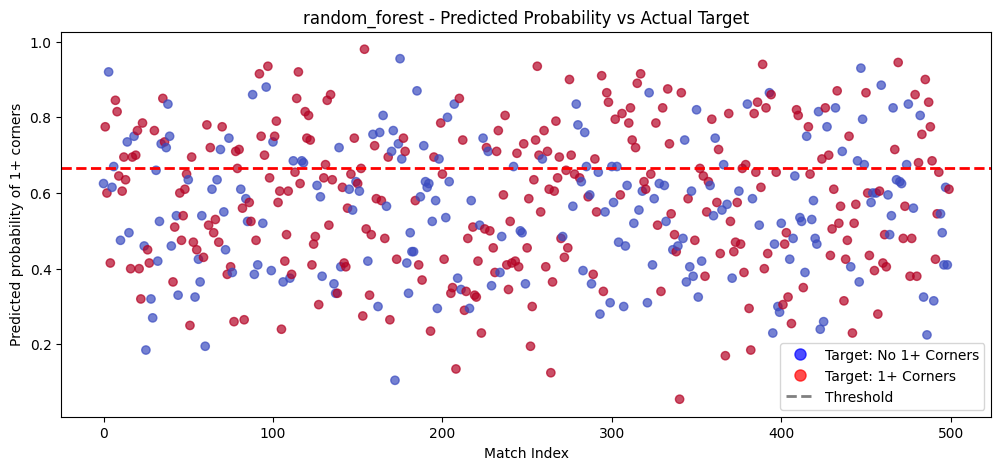


-> Running Backtest for random_forest...

📊 Betting Trade Summary:
Match ID   Odds       Stake      Profit     Outcome    Bank      
dCueCZOI/  1.45       100.00     45.38      1          1045.38   
zBEayApd/  1.46       104.54     48.45      1          1093.83   
dKLrKm2e/  1.44       109.38     48.17      1          1142.00   
fZsxqrxh/  1.46       114.20     -114.20    0          1027.80   
2DKlSrzn/  1.55       102.78     56.53      1          1084.33   
nPOSzoyG/  1.54       108.43     58.18      1          1142.51   
8d8BSMrd/  1.51       114.25     -114.25    0          1028.26   
dIz4YCWE/  1.55       102.83     56.16      1          1084.42   
pt2wtVOE/  1.46       108.44     49.63      1          1134.05   
juQ6O2gs/  1.47       113.41     53.00      1          1187.05   
OWjpEro0/  1.52       118.71     61.87      1          1248.92   
8tbIt2FP/  1.46       124.89     57.40      1          1306.32   
4lwgz0hg/  1.46       130.63     60.04      1          1366.36   
Qcvkytwm

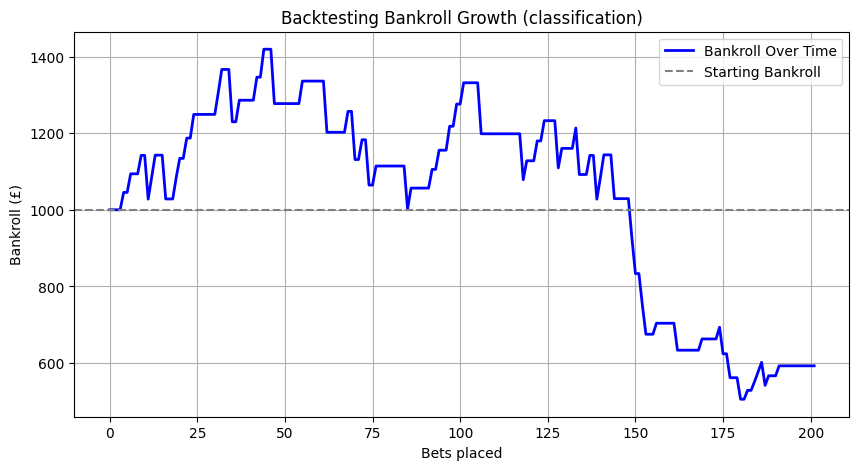


-> Training logistic_regression...

### Top 8 and Bottom 5 Feature Importance ###
                            Feature  Importance
14        trailing_team_probability    1.224996
10  trailing_team_urgency_to_attack    0.454368
8                        odds_ratio    0.267639
2          leading_team_shots_70_75    0.042977
1       trailing_team_corners_70_75    0.000000
3         trailing_team_shots_70_75    0.000000
5       trailing_team_corners_75_80    0.000000
7         trailing_team_shots_75_80    0.000000
0        leading_team_corners_70_75   -0.058668
12                 attack_intensity   -0.152782
4        leading_team_corners_75_80   -0.273308
13               defensive_pressure   -0.497451
9       shot_to_corner_ratio_pre_80   -0.710836

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.6512      0.5140      
0.52        0.6955      0.4298      
0.55        0.6860      0.3315      


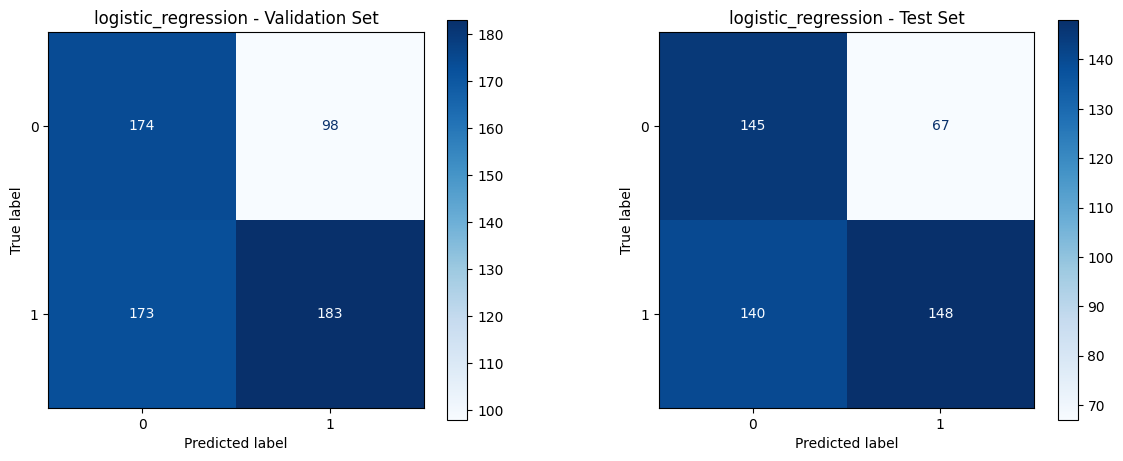

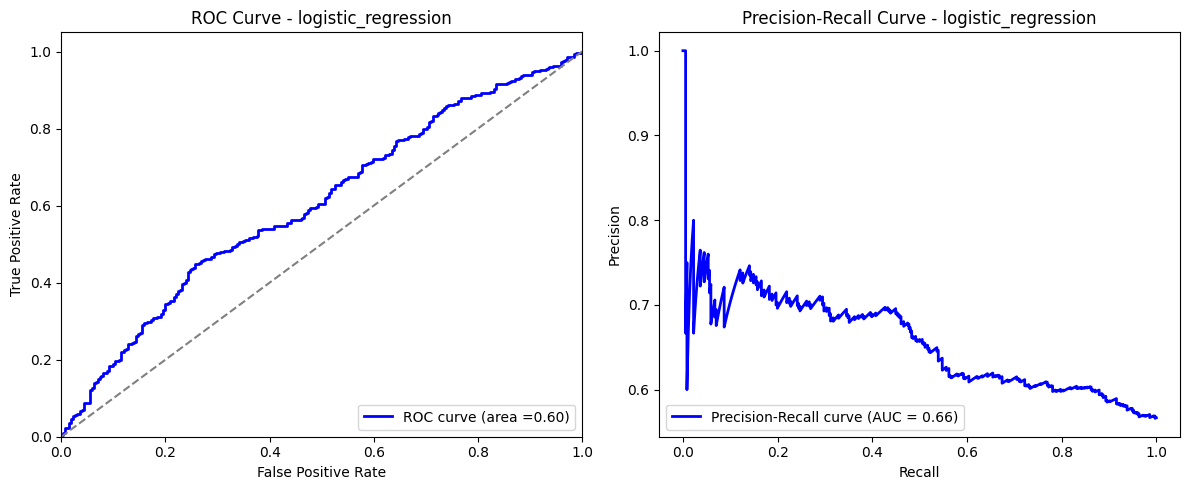

logistic_regression model saved.
Predictions saved for logistic_regression.


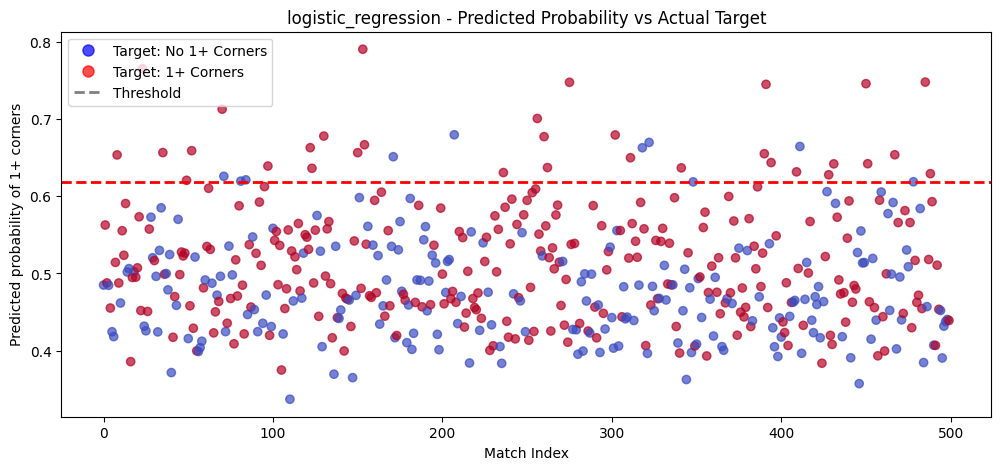


-> Running Backtest for logistic_regression...

📊 Betting Trade Summary:
Match ID   Odds       Stake      Profit     Outcome    Bank      
dKLrKm2e/  1.44       100.00     44.04      1          1044.04   
juQ6O2gs/  1.47       104.40     48.79      1          1092.83   
APSZzh01/  1.47       109.28     -109.28    0          983.55    
Qcvkytwm/  1.44       98.35      -98.35     0          885.20    
tfYHUeMU/  1.46       88.52      -88.52     0          796.68    
OWCFTNpm/  1.46       79.67      36.62      1          833.29    
f3u3HnNJ/  1.52       83.33      43.27      1          876.56    
vHKpbZbg/  1.48       87.66      41.64      1          918.20    
8G25iygp/  1.44       91.82      40.08      1          958.28    
8fLWJ7IE/  1.46       95.83      44.04      1          1002.33   
EevtcpB1/  1.46       100.23     -100.23    0          902.10    
hnwpd4Q7/  1.46       90.21      41.11      1          943.21    
pKA5gBDO/  1.46       94.32      43.71      1          986.93    
Ii

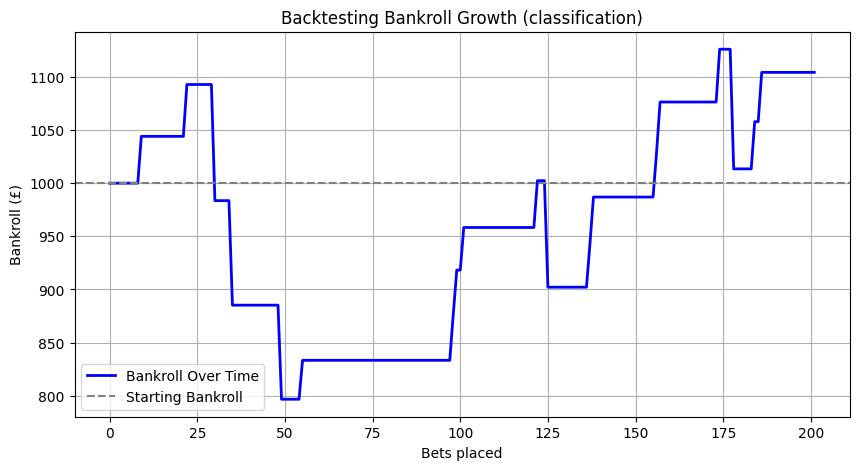


-> Training svc...

### Top 8 and Bottom 5 Feature Importance ###
                             Feature  Importance
0         leading_team_corners_70_75         0.0
1        trailing_team_corners_70_75         0.0
2           leading_team_shots_70_75         0.0
3          trailing_team_shots_70_75         0.0
4         leading_team_corners_75_80         0.0
5        trailing_team_corners_75_80         0.0
6           leading_team_shots_75_80         0.0
7          trailing_team_shots_75_80         0.0
10   trailing_team_urgency_to_attack         0.0
11  trailing_team_momentum_to_attack         0.0
12                  attack_intensity         0.0
13                defensive_pressure         0.0
14         trailing_team_probability         0.0

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.6073      0.7472      
0.52        0.6166      0.6461      
0.55        0.6411      0.5871      
0.

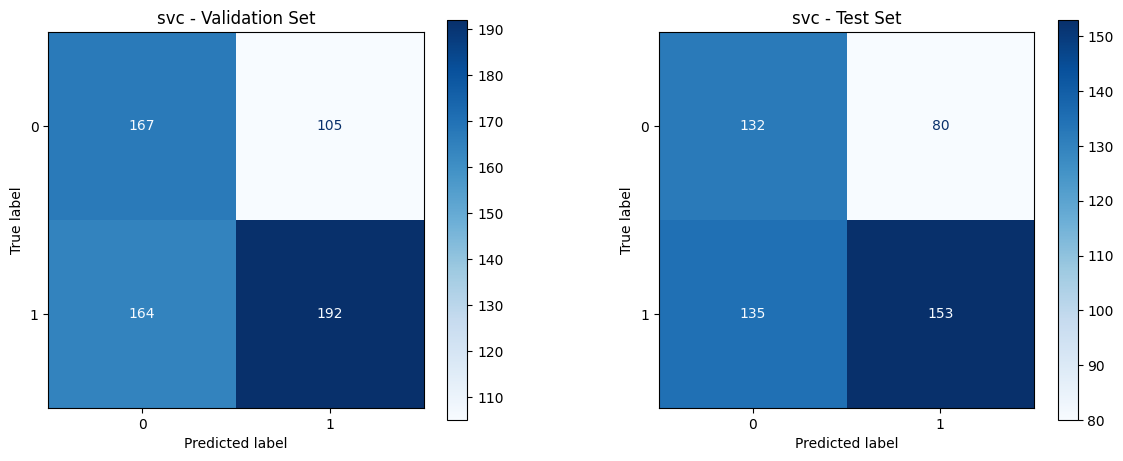

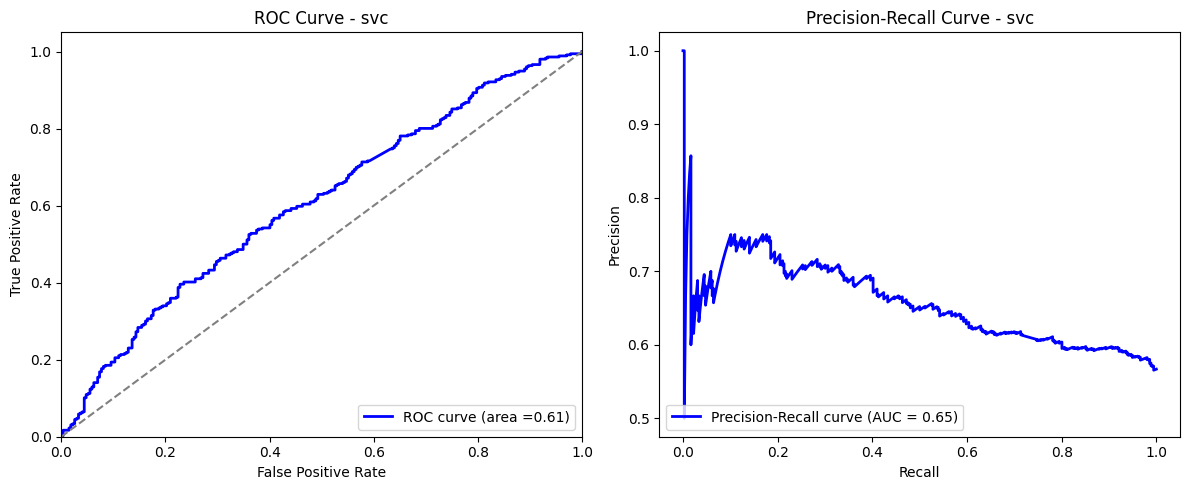

svc model saved.
Predictions saved for svc.


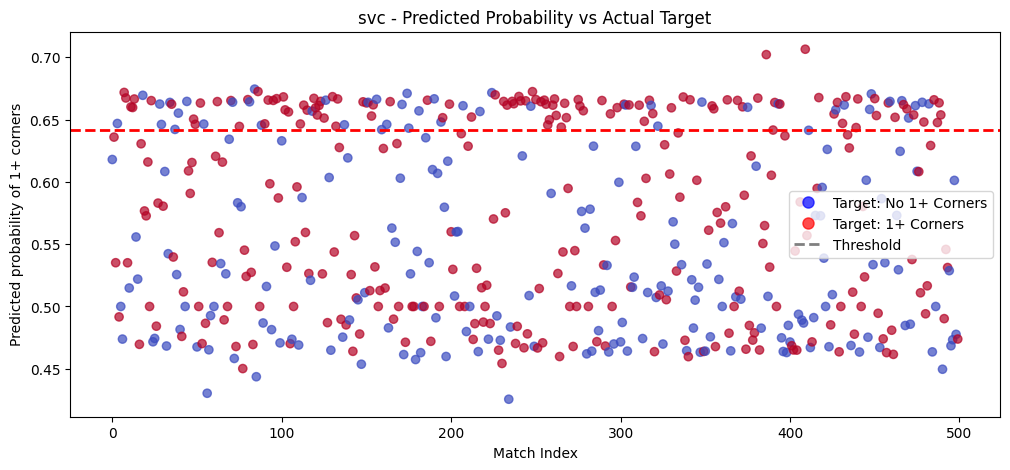


-> Running Backtest for svc...

📊 Betting Trade Summary:
Match ID   Odds       Stake      Profit     Outcome    Bank      
URKjXpwt/  1.45       100.00     45.38      1          1045.38   
zBEayApd/  1.46       104.54     48.45      1          1093.83   
dKLrKm2e/  1.44       109.38     48.17      1          1142.00   
fZsxqrxh/  1.46       114.20     -114.20    0          1027.80   
jLXezZ12/  1.46       102.78     46.84      1          1074.65   
juQ6O2gs/  1.47       107.46     50.22      1          1124.87   
OWjpEro0/  1.52       112.49     58.62      1          1183.49   
CpqeV8ne/  1.54       118.35     64.18      1          1247.67   
APSZzh01/  1.47       124.77     -124.77    0          1122.90   
8tbIt2FP/  1.46       112.29     51.61      1          1174.51   
Qcvkytwm/  1.44       117.45     -117.45    0          1057.06   
6LNXrSGf/  1.53       105.71     55.90      1          1112.97   
tfYHUeMU/  1.46       111.30     -111.30    0          1001.67   
OWCFTNpm/  1.46   

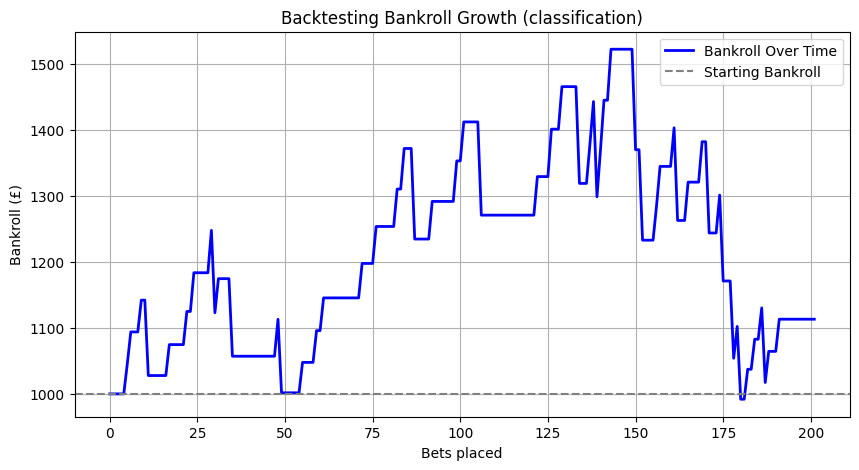


-> Training xgboost...

### Top 8 and Bottom 5 Feature Importance ###
                             Feature  Importance
10   trailing_team_urgency_to_attack    0.151234
14         trailing_team_probability    0.148979
2           leading_team_shots_70_75    0.101988
8                         odds_ratio    0.097991
9        shot_to_corner_ratio_pre_80    0.088552
13                defensive_pressure    0.087688
0         leading_team_corners_70_75    0.087150
4         leading_team_corners_75_80    0.080656
1        trailing_team_corners_70_75    0.000000
3          trailing_team_shots_70_75    0.000000
5        trailing_team_corners_75_80    0.000000
7          trailing_team_shots_75_80    0.000000
11  trailing_team_momentum_to_attack    0.000000

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.6053      0.7669      
0.52        0.6203      0.7022      
0.55        0.6319      0.6461     

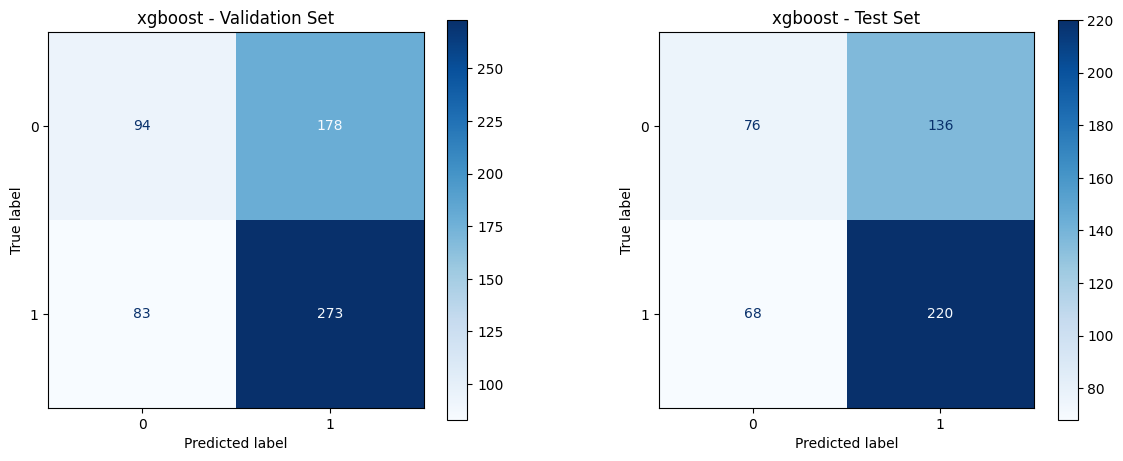

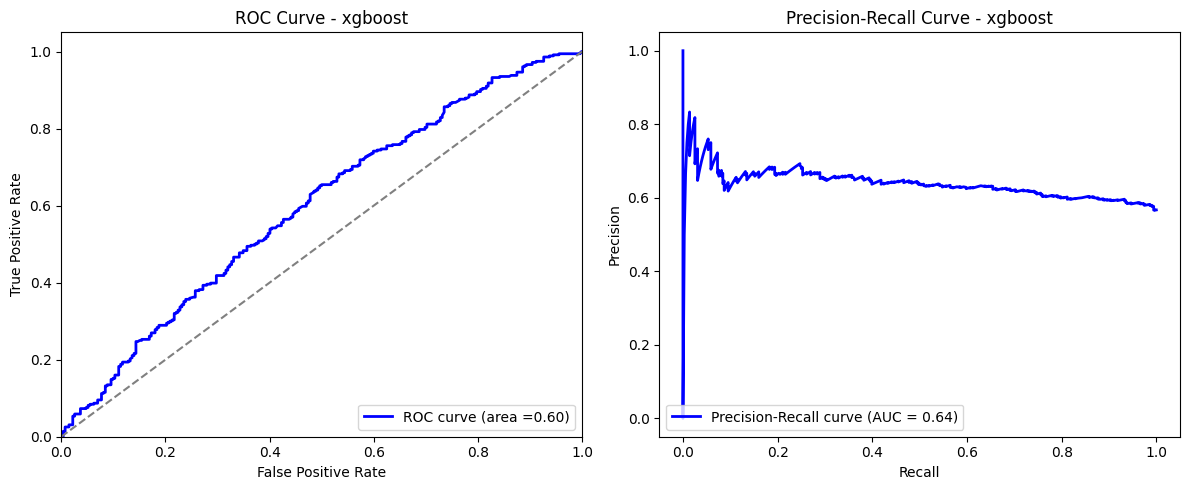

xgboost model saved.
Predictions saved for xgboost.


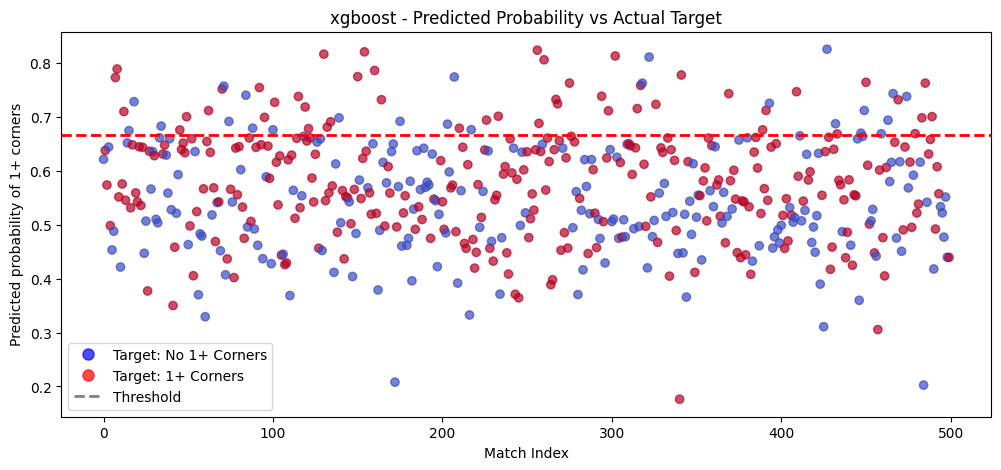


-> Running Backtest for xgboost...

📊 Betting Trade Summary:
Match ID   Odds       Stake      Profit     Outcome    Bank      
zBEayApd/  1.46       100.00     46.35      1          1046.35   
dKLrKm2e/  1.44       104.63     46.08      1          1092.42   
APSZzh01/  1.47       109.24     -109.24    0          983.18    
8tbIt2FP/  1.46       98.32      45.19      1          1028.37   
4lwgz0hg/  1.46       102.84     47.27      1          1075.64   
Qcvkytwm/  1.44       107.56     -107.56    0          968.08    
dAz2huli/  1.46       96.81      44.31      1          1012.39   
OWCFTNpm/  1.46       101.24     46.53      1          1058.92   
8vNtT32N/  1.47       105.89     49.48      1          1108.40   
OOphFvoi/  1.54       110.84     59.90      1          1168.30   
vHKpbZbg/  1.48       116.83     55.49      1          1223.79   
6TB1fibI/  1.46       122.38     -122.38    0          1101.41   
8fLWJ7IE/  1.46       110.14     50.62      1          1152.04   
hbNk8rp6/  1.4

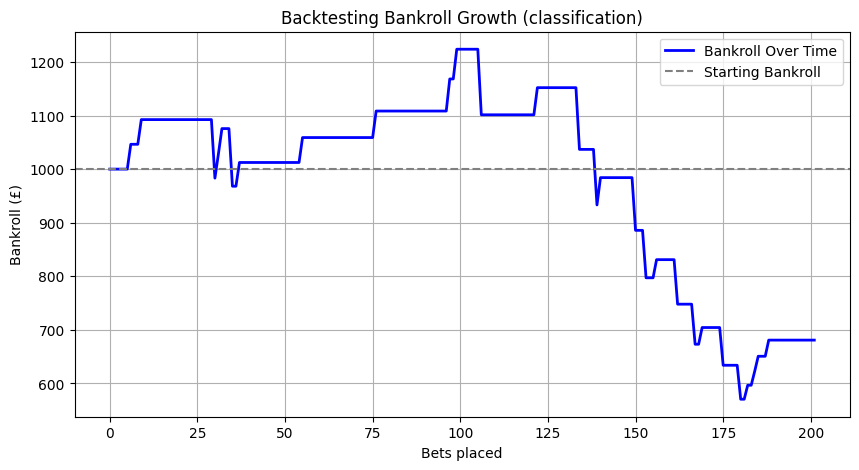

📄 Saved PDF Report
✅ Finished Running Pipeline


In [9]:
run_classification_pipeline(config, df_selected, selected_features, constructed_features, target_variable=target_variable[0], show_output=True, generate_pdf=True)